# Stock Price Indicator #
    
The scope of this project is the prediction of stock values, exploring various techniques. 

We are going to use data for stocks in [Athens Stock Exchange](https://en.wikipedia.org/wiki/Athens_Exchange) taken from [Naftemporiki](https://www.naftemporiki.gr/) financial greek newspaper.


<h2> Data Retrieval </h2>

In [1]:
# Import section

import csv
import io
import pandas as pd
import numpy as np
import requests
import time
from datetime import date, datetime, timedelta
#import math

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import *
import warnings

import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pylab import rcParams

%precision %.2f
%matplotlib inline

In [2]:
# Global Variables

# A selection of stocks with the higest market capitalisation are going to be used taken from here --> 
# https://www.naftemporiki.gr/finance/capitalization?market=ATH&tab=1&sort=desc

# list of symbols for selected stocks
symbols = ['EEE','HTO','OPAP','EUROB','PRODEA','ETE','PPC','BELA','MYTIL','ELPE','TENERGY','MOH']

# Specify date range for data
start_date='2016-01-01' # starting date
days_before = 5 # days before end date
end_date= date.today() - timedelta(days=days_before) # ending date

# Generic plot size
plt.rcParams['figure.figsize'] = (18,8)

**Get Data  - Specific stock**

In [3]:
def retrieve_stock_data(symbol):
    ''' 
    Retrieve data for a reference stock
    
    Input
    ------
    symbol: Symbol id for stock to be retrieved
    
    Output
    ------
    df: Dataframe with stock data for specific symbol
    
    '''

    # URL where data resides 
    url = 'https://www.naftemporiki.gr/finance/Data/getHistoryData.aspx?symbol='+symbol+'.ATH&type=csv'

    from requests.exceptions import ConnectionError
    '''
    try:
       r = requests.get("http://example.com", timeout=0.001)
    except ConnectionError as e:    # This is the correct syntax
       print e
       r = "No response"    
    '''  
    try:
        # Get Data
        s = requests.get(url).content
        df = pd.read_csv(io.StringIO(s.decode('utf-8')), delimiter=";", decimal=",", na_values=['Nan']) # index_col='Trade Date',parse_dates=True,
    except ConnectionError as e:    # This is the correct syntax
        print(e)
        df = None 
        #exit(1)
        raise SystemExit("Connectivity Issue!")
    
    
    return df

def explore_df(df):
    ''' 
    Initially explore data
    
    Input
    ------
    df: Dataframe with stock data for specific symbol
    
    '''
    print('\nShape:', df.shape)   # data shape    
    print('\nDataset : ')
    print(df.head(2)) # starting rows
    print(df.tail(2)) # ending rows
    print('\nData Info : ')        
    print(df.describe())
    

In [4]:
# Get data for a sample stock
df = retrieve_stock_data('EEE')


# Initially explore data
explore_df(df) 


Shape: (1244, 10)

Dataset : 
  Trade Date   High    Low   Open  Close  Volume  Prev. Close  Total Turnover  \
0   2/3/2016  17.98  17.51  17.81  17.51   74696        17.82       1322081.0   
1   3/3/2016  17.87  17.49  17.67  17.84   10749        17.51        190705.0   

   Num. Of Trans.  Unnamed: 9  
0             205         NaN  
1              67         NaN  
     Trade Date   High    Low   Open  Close  Volume  Prev. Close  \
1242  26/2/2021  26.48  25.80  26.31  25.96   44983        26.88   
1243   1/3/2021  26.45  25.97  26.28  26.36   42954        25.96   

      Total Turnover  Num. Of Trans.  Unnamed: 9  
1242       1170824.0             302         NaN  
1243       1123296.0             189         NaN  

Data Info : 
              High          Low         Open        Close         Volume  \
count  1244.000000  1244.000000  1244.000000  1244.000000    1244.000000   
mean     25.952174    25.476551    25.714980    25.709534   35449.091640   
std       4.428188     4.3919

**Get & Clean Data - Multiple Stocks (Closing Price)**

In [5]:
# Create DataFrame with multiple stocks

# site url
url1 = 'https://www.naftemporiki.gr/finance/Data/getHistoryData.aspx?symbol='
url2 = '.ATH&type=csv'

#start_date='2016-01-01'
#days_before = 5
#end_date= date.today() - timedelta(days=days_before)
dates = pd.date_range(start_date, end_date)

# Initiate DataFrame with DatetimeIndex
df_stocks = pd.DataFrame(index=dates)
#df_stocks = pd.DataFrame()


# --> Read in a reference stock (here SPY) and drop non-trading days using pandas.DataFrame.dropna

# Fetch stocks and incrementally join to DataFrame
for symbol in symbols:
    
    s=requests.get(url1+symbol+url2).content    
    df_all=pd.read_csv(io.StringIO(s.decode('utf-8')), delimiter=";", decimal=",", na_values=['Nan'], usecols=['Trade Date','Close']) # index_col='Trade Date', parse_dates=True,
    df_all['Trade Date']= pd.to_datetime(df_all['Trade Date'], format='%d/%m/%Y')
    df_all.set_index('Trade Date', inplace = True)
    df_all.rename(columns={"Close": symbol}, inplace=True)
    df_stocks = df_stocks.join(df_all)

# Remove NaN values
print(df_stocks.shape)
df_stocks.dropna(inplace=True)
print(df_stocks.shape)

(1883, 12)
(1242, 12)


In [6]:
df_stocks.tail()

,EEE,HTO,OPAP,EUROB,PRODEA,ETE,PPC,BELA,MYTIL,ELPE,TENERGY,MOH
2021-02-19,26.60,12.31,10.45,0.559,8.0,2.019,9.330,13.35,12.80,5.45,12.30,11.50
2021-02-22,26.28,12.20,10.42,0.562,8.0,2.063,9.300,13.28,12.60,5.41,12.70,11.36
2021-02-23,26.32,12.12,10.34,0.570,8.0,2.070,8.755,13.00,12.36,5.43,12.20,11.29
2021-02-24,26.28,12.10,10.53,0.578,8.0,2.054,8.585,12.90,12.39,5.42,12.40,11.30
2021-02-25,26.88,12.44,10.82,0.590,8.0,2.087,8.785,13.04,12.79,5.44,12.06,11.35


In [7]:
df_stocks['EEE'].loc['2010-11-30':'2020-12-02']

2016-03-02    17.51
2016-03-03    17.84
2016-03-04    17.74
2016-03-07    18.23
2016-03-08    17.90
              ...  
2020-11-26    24.43
2020-11-27    24.38
2020-11-30    23.82
2020-12-01    24.10
2020-12-02    24.52
Name: EEE, Length: 1185, dtype: float64

<h2> Data Cleaning </h2>

In [8]:
def clean_stock_data(df, start_date, end_date):
    ''' 
    Clean stock data
    
    Input
    ------
    df: Dataframe with stock data
    
    Output
    ------
    df: Dataframe with stock data after cleansing
    
    '''
    
    # Create index dates DataFrame
    dates = pd.date_range(start_date, end_date) # Create DatetimeIndex   
    df_dates = pd.DataFrame(index=dates) # create the dataframe

    # Create index
    df['Date']= pd.to_datetime(df['Trade Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace = True)
    
    # Drop irrelevant columns
    #df = df.drop('Date', axis=1) 
    df = df.drop('Trade Date', axis=1) 
    df = df.drop('Unnamed: 9', axis=1) 
    df = df.drop('Prev. Close', axis=1) 

    # Add to stocks DataFrame so that we align stock data by trading date
    df = df_dates.join(df)
        
    df.dropna(inplace=True)
        
    return df

In [9]:
explore_df(df)

df_all_data = clean_stock_data(df, start_date, end_date)

print('\n\nDataset after data clean: ')
df_all_data.head()


Shape: (1244, 10)

Dataset : 
  Trade Date   High    Low   Open  Close  Volume  Prev. Close  Total Turnover  \
0   2/3/2016  17.98  17.51  17.81  17.51   74696        17.82       1322081.0   
1   3/3/2016  17.87  17.49  17.67  17.84   10749        17.51        190705.0   

   Num. Of Trans.  Unnamed: 9  
0             205         NaN  
1              67         NaN  
     Trade Date   High    Low   Open  Close  Volume  Prev. Close  \
1242  26/2/2021  26.48  25.80  26.31  25.96   44983        26.88   
1243   1/3/2021  26.45  25.97  26.28  26.36   42954        25.96   

      Total Turnover  Num. Of Trans.  Unnamed: 9  
1242       1170824.0             302         NaN  
1243       1123296.0             189         NaN  

Data Info : 
              High          Low         Open        Close         Volume  \
count  1244.000000  1244.000000  1244.000000  1244.000000    1244.000000   
mean     25.952174    25.476551    25.714980    25.709534   35449.091640   
std       4.428188     4.3919

,High,Low,Open,Close,Volume,Total Turnover,Num. Of Trans.
2016-03-02,17.98,17.51,17.81,17.51,74696.0,1322081.0,205.0
2016-03-03,17.87,17.49,17.67,17.84,10749.0,190705.0,67.0
2016-03-04,18.09,17.74,17.84,17.74,59758.0,1066810.0,187.0
2016-03-07,18.23,17.75,17.78,18.23,18960.0,342530.0,93.0
2016-03-08,18.13,17.86,17.93,17.90,72885.0,1309791.0,218.0


<h2> Explore Data - Visualisations</h2>

**Visualise Price and Volume for sample stock**

<Figure size 1296x576 with 0 Axes>

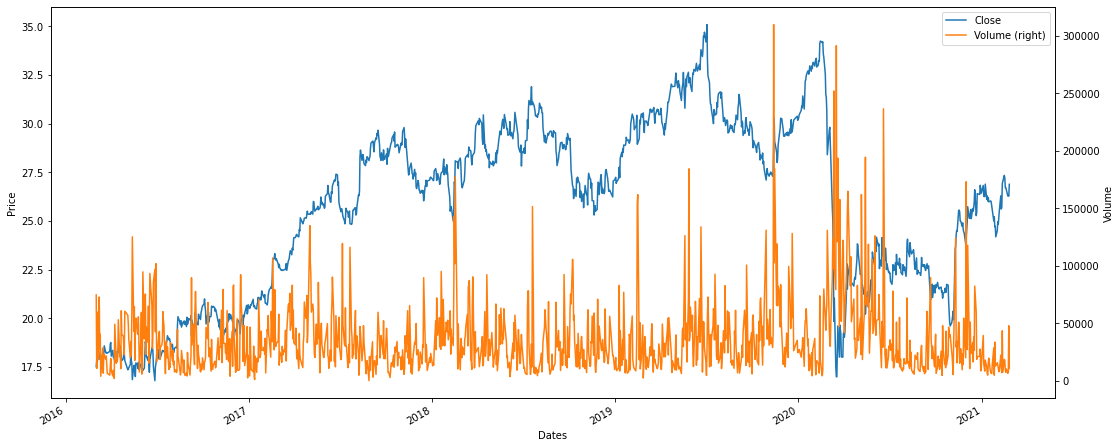

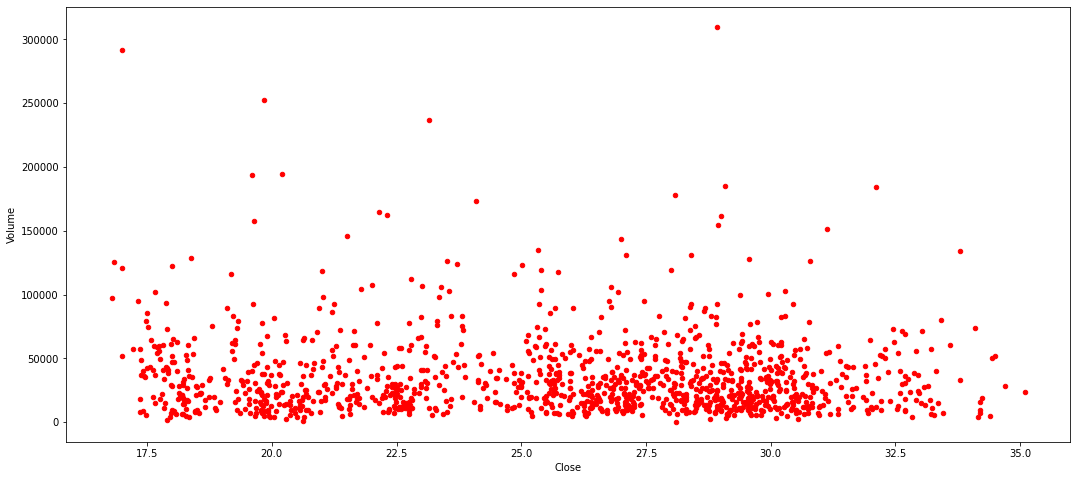

In [10]:
# Select Close Price and Volume
data = df_all_data[['Close','Volume']]


# Plot Closing Price and Volume Time Series
fig = plt.figure();
ax = data.plot(secondary_y=["Volume"]);
ax.set_xlabel('Dates')
ax.set_ylabel('Price')
ax.right_ax.set_ylabel("Volume");


# Plot relationship between Closing Price and Volume 
data.plot.scatter( x='Close', y='Volume', color='r');

**Visualise Close Price for all stocks**

In [11]:
# Plot Stock(s)
def plotdf(df, title = 'Stock Prices', stocks = None, start_d = None, end_d = None, df2 = None, xlabel='Date', ylabel='Price'):
    '''
    Plots Stock Time Series
    
    Input
    ------
    df: Dataframe
    title: Plot title (string)
    stocks: Stock symbols (string of a symbol, list of symbols)
    start_d: Start Date ('yyyy-mm-dd')
    end_d: End Date ('yyyy-mm-dd')
    df2: Additional Dataframe 
    xlabel: Label for x axis 
    ylabel: Label for y axis
    '''
    
    if stocks is not None:
        df = df[stocks]     
        
    if (start_d is not None) or (end_d is not None):
        df = df.loc[start_d:end_d]     
      
    df = df.loc[start_d:end_d]
    
    
    if df2 is not None:
        if (start_d is not None) or (end_d is not None):
            df2 = df2.loc[start_d:end_d]
        if stocks is not None:
            df2 = df2[stocks]     
            
        df2 = df2.loc[start_d:end_d]                        
    
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if df2 is not None:
        df2.plot(ax = ax)
        ax.legend()
        
    plt.show()

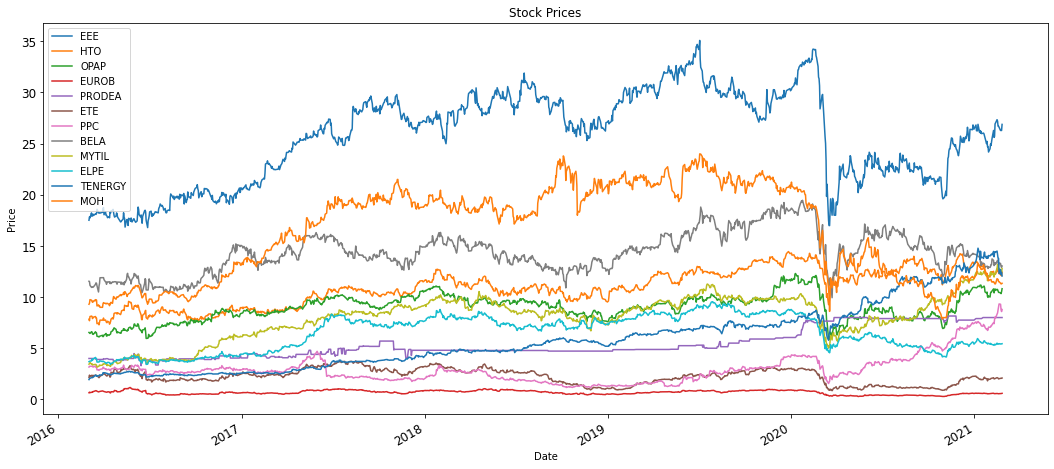

In [12]:
# Plot all Stocks
plotdf(df_stocks)

In [13]:
# Normalised Prices
def normalise(df, start_d = None, end_d = None):
    '''
    Normalise stock prices on first data row
    
    Input
    ------
    df: Dataframe
    start_d: Start Date ('yyyy-mm-dd')
    end_d: End Date ('yyyy-mm-dd')
    
    Output
    ------  
    df_norm: Dataframe with normalised values
    '''
    
    if (start_d is not None) and (end_d is not None):
        df_norm = df.loc[start_d:end_d].div(df.loc[start_d:end_d].iloc[0,:], axis=1)
    else:
        df_norm = df.div(df.iloc[0,:], axis=1)
        
        
    return df_norm

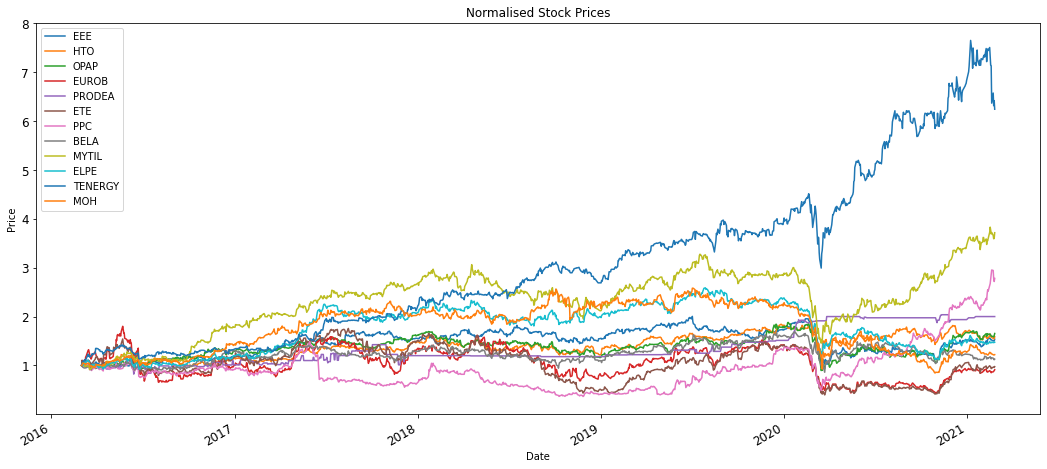

In [14]:
# Plot all Stocks normalised
df_norm = normalise(df_stocks)
title = 'Normalised Stock Prices'

plotdf(df_norm, title)

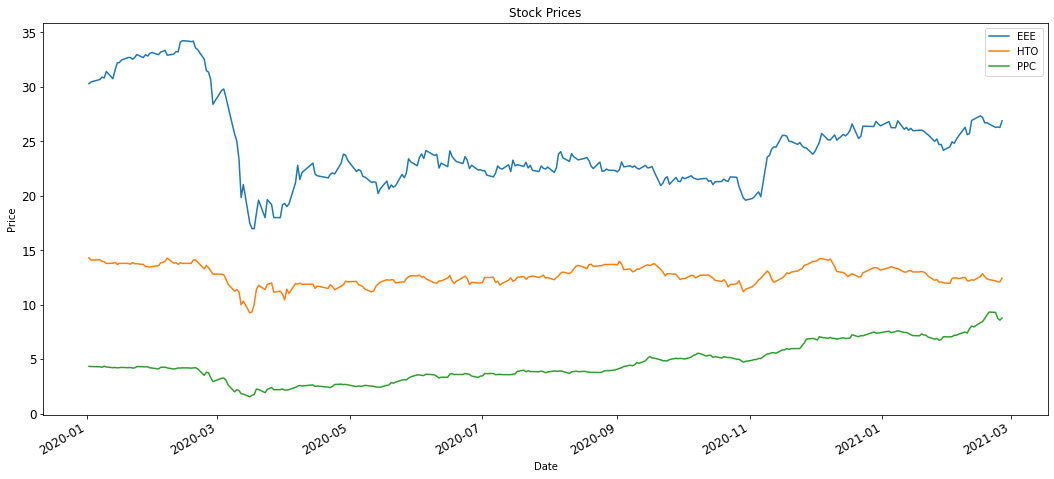

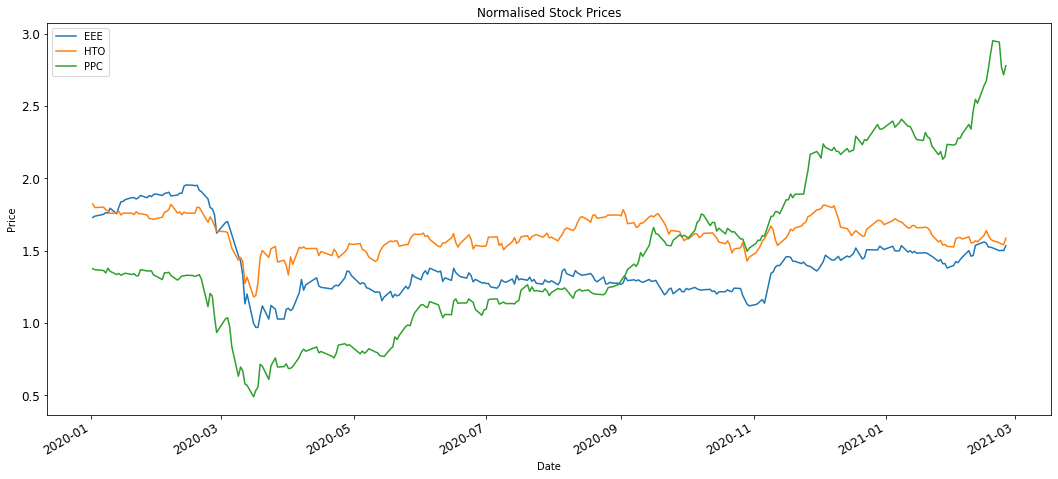

In [15]:
# Select Stocks and date range
symbols = ['EEE','HTO','PPC']
start_d = '2020-01-02'
#end_d = '2020-12-02'
title = 'Stock Prices'

# Plot the Stocks
plotdf(df_stocks, title, symbols, start_d)

# Normalise Prices
df_norm = normalise(df_stocks, start_d)

# Plot the Stocks with normalised prices
title = 'Normalised Stock Prices'
plotdf(df_norm, title, symbols, start_d)

In [16]:
#df_stocks.mean(), df_stocks.median(), df_stocks.std()

<h2>Technical Analysis</h2>

Technical Analysis is an analysis methodology for forecasting the direction of prices through the study of past market data, primarily price and volume.

In [17]:
# Select Stock and date range
symbol = 'EEE'
start_d = '2020-02-03' #CHECK  CHECK CHECK CHECK 
end_d = '2021-02-01'

**Bollinger Bands**

In [18]:
def bollinger_bands(df, symbol, start_d, end_d, rolling_num = 20):
    '''
    Bollinger Bands is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively)
    away from a simple moving average (SMA) of a stock's price, but which can be adjusted to user preferences.
    Bollinger Bands = mean (+- std) ** 2
    
    Input
    ------
    df: Dataframe
    symbol: Stock symbol
    start_d: Start Date ('yyyy-mm-dd')
    end_d: End Date ('yyyy-mm-dd')
    rolling_num: no of past days to be used
    
    Output
    ------  
    df_rol: Dataframe with bollinger bands related values
    '''

    rol = df[symbol].loc[start_d:].rolling(rolling_num).mean()
    rol_std = df[symbol].loc[start_d:].rolling(rolling_num).std()
    rol_std_up = rol + 2 * rol_std
    rol_std_down = rol - 2 * rol_std

    df_rol = pd.DataFrame()
    #df_rol['Rolling Mean'] = rol
    df_rol['Price'] = df[symbol].loc[start_d:]
    df_rol['STD Above'] = rol_std_up
    df_rol['STD Below'] = rol_std_down
    
    return df_rol


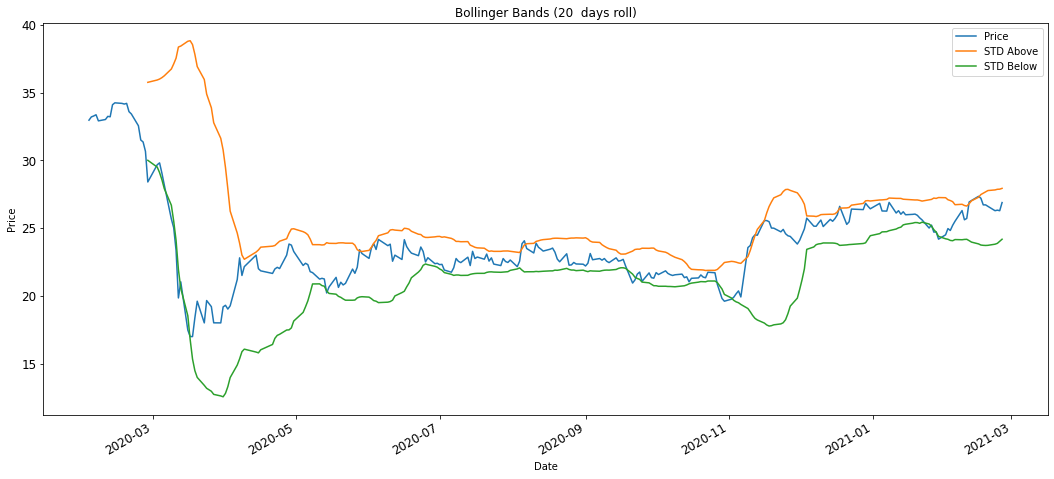

In [19]:
title = 'Bollinger Bands (20  days roll)'

df_rol = bollinger_bands(df_stocks, symbol, start_d, end_d)

# Plot Bollinger Bands 
plotdf(df_rol, title)


**Daily Rerurns**

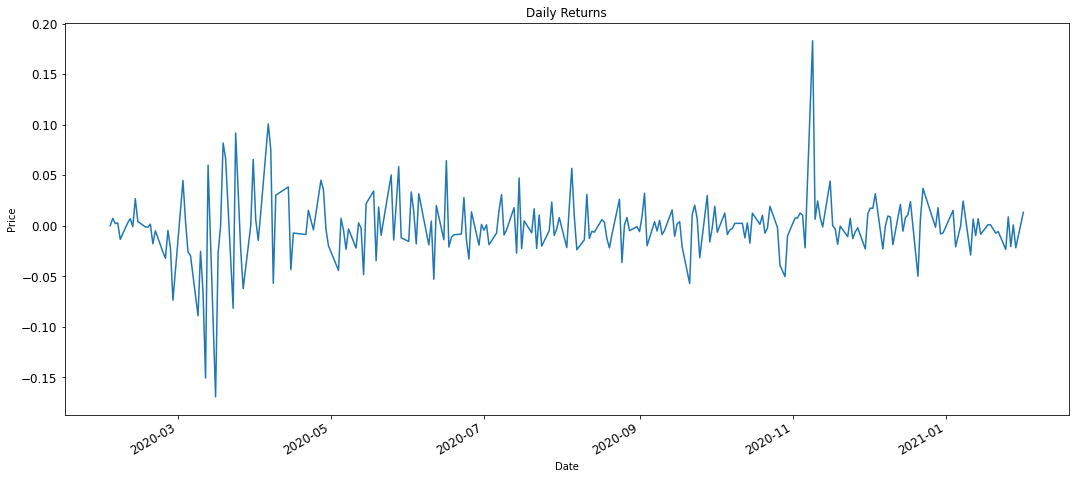

In [20]:
def daily_returns(df, symbol, start_d, end_d):
    '''
    Daily Returns measures the change in a stock's price as a percentage of the previous day's closing price.
    A stock with lower positive and negative daily returns is typically less risky than a stock with higher daily returns.
    
    Input
    ------
    df: Dataframe
    symbol: Stock symbol
    start_d: Start Date ('yyyy-mm-dd')
    end_d: End Date ('yyyy-mm-dd')
    
    Output
    ------  
    daily_ret: Dataframe with daily returns
    '''    
    daily_ret = (df[symbol].loc[start_d:end_d]/df[symbol].loc[start_d:end_d].shift(1))-1
    daily_ret.iloc[0,:] = 0
    daily_ret.dropna(inplace=True)
    
    return daily_ret

daily_ret = daily_returns(df_stocks, symbol, start_d, end_d)

plotdf(daily_ret, 'Daily Returns')

**Histogram of Daily returns (Mean - Standard Deviation - Kurtosis)**

Mean: -0.00068  -  Standard Deviation: 0.03  -  Kurtosis: 8.93


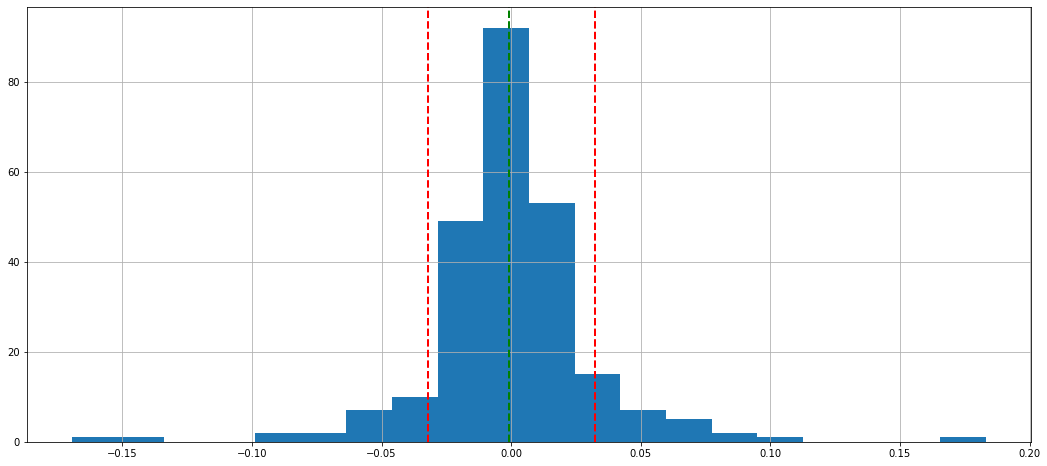

In [21]:
def daily_ret_hist(daily_ret):
    '''   
    Create histogram of daily returns 
    We are considering two general properties indicated by the histogram for each stock: return and volatility (or risk).
    broader shoulders, (lower mean), larger standard deviation, higer volatility
    
    Input
    ------
    daily_ret: Dataframe with daily returns
    '''    
    
    ax = daily_ret.hist(label='Price',  bins=20)
    mean = daily_ret.mean() # Mean
    std = daily_ret.std() # Standard Deviation
    kurtosis = daily_ret.kurtosis() # Kurtosis
    ax.axvline(mean, linestyle='dashed', color='g', linewidth=2)
    ax.axvline(std, linestyle='dashed', color='r', linewidth=2)
    ax.axvline(-std, linestyle='dashed', color='r', linewidth=2)
    print('Mean:', "{:.5f}".format(mean), ' -  Standard Deviation:', "{:.2f}".format(std), ' -  Kurtosis:', "{:.2f}".format(kurtosis)   )
    
# --> Add line 

daily_ret_hist(daily_ret) 
#Kurtosis: we have skinny tails

**Cummulative Return**

In [22]:
# Cummulative Return
def cummulative_return(df, symbol, start_d, end_d):
    '''
    A cumulative return on an investment is the amount that the investment has gained or lost over time, 
    independent of the amount of time involved. 
    cummulative_return = (price_end - price_start) - 1
    
    Input
    ------
    df: Dataframe
    symbol: Stock symbol
    start_d: Start Date ('yyyy-mm-dd')
    end_d: End Date ('yyyy-mm-dd')
    '''        

    cum_ret = (df[symbol].loc[end_d] - df[symbol].loc[start_d]) / df[symbol].loc[start_d]
    print ("Cummulative Return [",symbol, '] =  ', "{:.2f}".format(cum_ret*100) , '%')

In [23]:
cummulative_return(df_stocks, symbol, start_d, end_d)

Cummulative Return [ EEE ] =   -25.67 %


**Correlation between stocks - Stock Protfolio**

A usufull statistic, especially if one possesses a stock portfolio, is the correlation coefficient. It is measured on a scale from -1 to 1. A correlation coefficient of 1 indicates a perfect positive correlation between the prices of two stocks, meaning the stocks always move the same direction by the same amount. A coefficient of -1 indicates a perfect negative correlation, meaning that the stocks have historically always moved in the opposite direction. If two stocks have a correlation coefficient of 0, it means there is no correlation and, therefore, no relationship between the stocks. Also the higher is the slope the higher is the β (beta).

beta = 0.3995759294186307  alpha = -0.00023613738715826606
correlation: 
           EEE       HTO       PPC      OPAP
EEE   1.000000  0.508554  0.564214  0.589883
HTO   0.508554  1.000000  0.584441  0.478296
PPC   0.564214  0.584441  1.000000  0.639648
OPAP  0.589883  0.478296  0.639648  1.000000

beta = 0.328681913379503  alpha = -0.0012859307471664273
correlation: 
           EEE       HTO       PPC      OPAP
EEE   1.000000  0.508554  0.564214  0.589883
HTO   0.508554  1.000000  0.584441  0.478296
PPC   0.564214  0.584441  1.000000  0.639648
OPAP  0.589883  0.478296  0.639648  1.000000



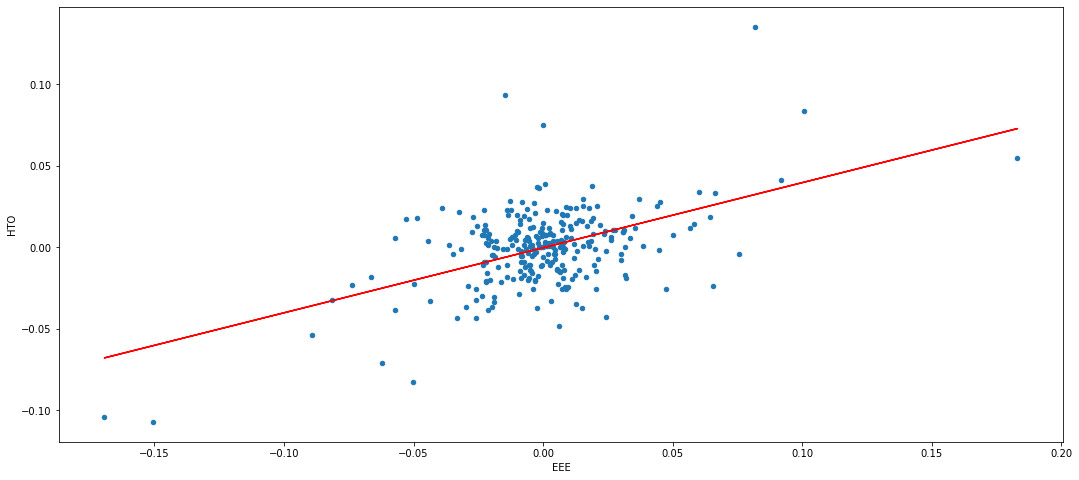

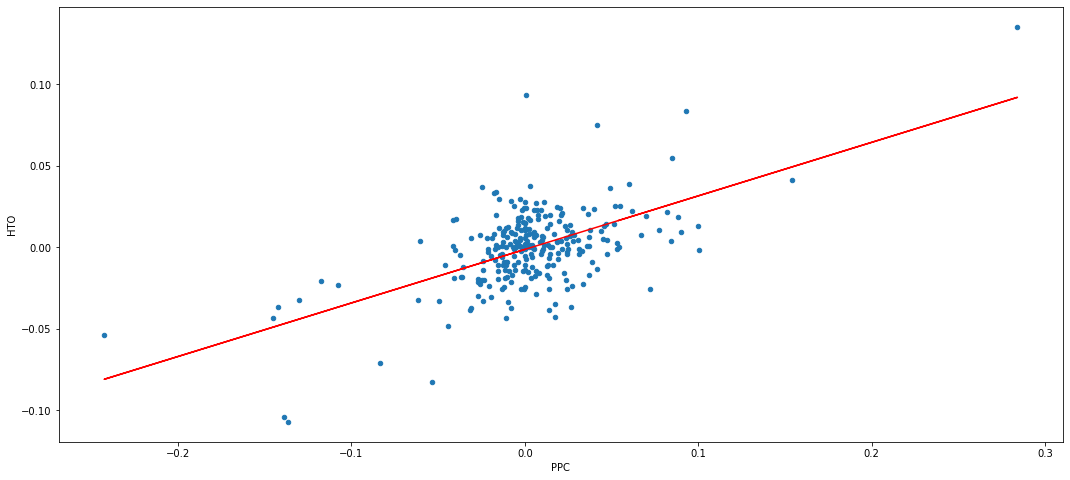

In [24]:
# Symbols to act as a sample trader portfolio
symbols = ['EEE','HTO','PPC','OPAP']
start_d = '2020-01-02'
end_d = '2021-02-10'

daily_ret = daily_returns(df_stocks, symbols, start_d, end_d)
daily_ret


def scatter(df, xx, yy):
    daily_ret.plot.scatter( x=xx, y=yy)
    b, a = np.polyfit(df[xx], df[yy], 1)
    print('beta =', b,' alpha =', a)
    print('correlation: ')
    print(daily_ret.corr(method='pearson')) 
    print()
    plt.plot(df[xx], b * daily_ret[xx] + a, '-', color='r')
    
scatter(daily_ret, 'EEE', 'HTO') 
scatter(daily_ret, 'PPC', 'HTO')    

**Daily Portfolio Value** 

When one possesses a stock portfolio it is required to know the value of this portfolio

In [25]:
#portf = ['ALPHA','TATT','EUROB','TPEIR']
portf = symbols[:4]
print(portf)
allocs = [0.1, 0.1, 0.4, 0.4]
start_val = 100000

df_portf = df_stocks[portf].loc[start_d:]
df_portf.head(5), df_portf.tail(1)

['EEE', 'HTO', 'PPC', 'OPAP']


(              EEE    HTO    PPC    OPAP
 2020-01-02  30.30  14.30  4.350  11.790
 2020-01-03  30.46  14.10  4.326  11.620
 2020-01-07  30.68  14.13  4.310  11.830
 2020-01-08  30.90  13.98  4.256  11.750
 2020-01-09  30.82  13.94  4.360  12.239,
               EEE    HTO    PPC   OPAP
 2021-02-25  26.88  12.44  8.785  10.82)

In [26]:
# Normalise on first day
df_normed = df_portf/df_portf.iloc[0]

# Allocated percentages to each stock
df_alloced = df_normed * allocs

# Daily value of each stock in portfolio
df_pos_vals = df_alloced * start_val

# Daily Total of portfolio
port_val = df_pos_vals.sum(axis=1)

df_pos_vals.head(5)

,EEE,HTO,PPC,OPAP
2020-01-02,10000.000000,10000.000000,40000.000000,40000.000000
2020-01-03,10052.805281,9860.139860,39779.310345,39423.240034
2020-01-07,10125.412541,9881.118881,39632.183908,40135.708227
2020-01-08,10198.019802,9776.223776,39135.632184,39864.291773
2020-01-09,10171.617162,9748.251748,40091.954023,41523.324852


In [27]:
port_val.head(5)

2020-01-02    100000.000000
2020-01-03     99115.495519
2020-01-07     99774.423558
2020-01-08     98974.167535
2020-01-09    101535.147785
dtype: float64

In [28]:
# Daily returns
daily_rets = (port_val/port_val.shift(1))-1
daily_rets = daily_rets[1:]
daily_rets

2020-01-03   -0.008845
2020-01-07    0.006648
2020-01-08   -0.008021
2020-01-09    0.025875
2020-01-10   -0.002902
                ...   
2021-02-19    0.017726
2021-02-22   -0.004041
2021-02-23   -0.038571
2021-02-24   -0.007125
2021-02-25    0.024724
Length: 286, dtype: float64

In [29]:
# Other Metrics

# Cummulative return
cum_ret = (port_val[-1]/port_val[0])-1

# Average Daily Return
avg_daily_ret = daily_rets.mean()

# Standard Deviation of Daily Returns  -- Risk
std_daily_ret = daily_rets.std()

print('\nCummulative return:',cum_ret, '\nAverage Daily Return:', avg_daily_ret, '\nRisk (Standard Deviation of Daily Returns):', std_daily_ret)


Cummulative return: 0.35061272511117325 
Average Daily Return: 0.0015018842526254334 
Risk (Standard Deviation of Daily Returns): 0.029690144444463763


**Sharpe Ratio** 

Sharpe Ratio is the risk adjusted return. I is the average return earned in excess of the risk-free rate per unit of volatility or total risk. 
Volatility is a measure of the price fluctuations of an asset or portfolio. All else being equal it may indicate better lower risk and higher return. 
Sharpe Ratio is an annual measure.


In [30]:
#Formula for computing Sharpe ratio:

# Contant definition
_daily_rf_ = 0.0002

# Daily Sampling
k = np.sqrt(252)

# Sharpe Ratio
sharpe_ratio = k * (avg_daily_ret - _daily_rf_) / std_daily_ret
print('\nSharp Ratio:',sharpe_ratio)


Sharp Ratio: 0.6960818883210986


## Long short-term memory (LSTM) ##

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture that is used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections.
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.

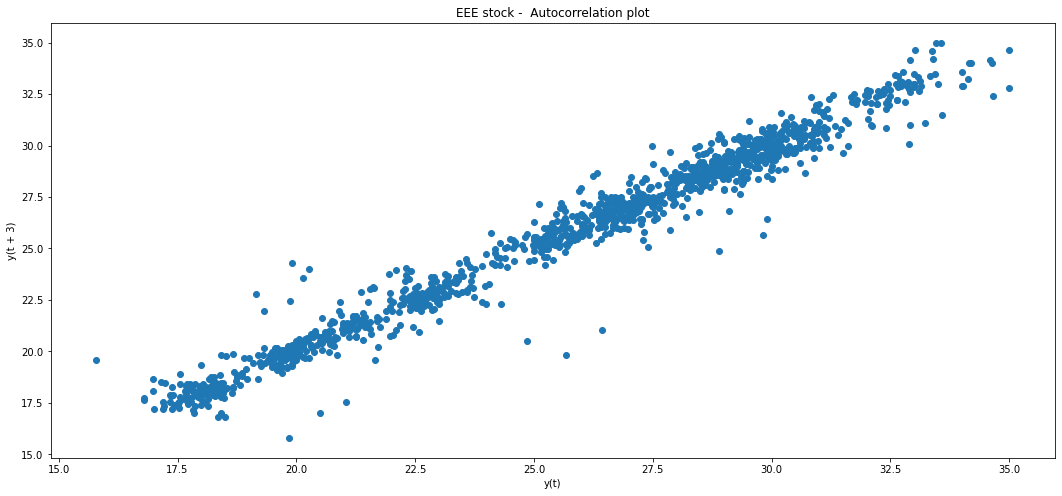

In [31]:
# Create Autocorrelation plot values
plt.figure()


# Check for patterns in time series data.
lag_plot(df['Open'], lag=3)
plt.title(symbol + " stock -  Autocorrelation plot")
plt.show()

In [32]:
# Create training and test datasets

perc = 0.8 # percentage of training data
split = int(df.shape[0] * perc) #800

training_set = df.iloc[:split, 3:4].values
test_set = df.iloc[split:, 3:4].values


In [33]:
# Feature Scaling
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output

days = 60
days = 30

X_train = []
y_train = []
for i in range(days, split):
    X_train.append(training_set_scaled[i-days:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [34]:
# LSTM Create and Fit Model
units = 100
epochs = 100

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = units, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = units, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = units))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
%time model.fit(X_train, y_train, epochs = epochs, batch_size = 32)

Epoch 1/100
31/31 [==============================] - 10s 91ms/step - loss: 0.0714
Epoch 2/100
31/31 [==============================] - 2s 79ms/step - loss: 0.0076
Epoch 3/100
31/31 [==============================] - 3s 90ms/step - loss: 0.0070
Epoch 4/100
31/31 [==============================] - 3s 97ms/step - loss: 0.0058
Epoch 5/100
31/31 [==============================] - 3s 89ms/step - loss: 0.0049
Epoch 6/100
31/31 [==============================] - 3s 88ms/step - loss: 0.0057
Epoch 7/100
31/31 [==============================] - 3s 91ms/step - loss: 0.0054
Epoch 8/100
31/31 [==============================] - 3s 89ms/step - loss: 0.0043
Epoch 9/100
31/31 [==============================] - 3s 90ms/step - loss: 0.0046
Epoch 10/100
31/31 [==============================] - 3s 87ms/step - loss: 0.0046
Epoch 11/100
31/31 [==============================] - 3s 96ms/step - loss: 0.0043
Epoch 12/100
31/31 [==============================] - 3s 90ms/step - loss: 0.0042
Epoch 13/100
31/31 [====

In [35]:
# save specific model for future use
#model.save('models/' + symbol + '-model.lstm')

In [36]:
# Create predicted stock price 
all_set = np.append(training_set, test_set)

# test + days
input_set = all_set[len(all_set) - len(test_set) - days:]

print('len inputs: ',len(input_set))

input_set = input_set.reshape(-1,1)

input_set = scaler.transform(input_set)


X_test = []
for i in range(days, days+len(test_set)):
    X_test.append(input_set[i-days:i, 0]) 

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#print('X_test.shape: ', X_test.shape)

predicted_set_norm = model.predict(X_test)
predicted_set = scaler.inverse_transform(predicted_set_norm)

predicted_set[-10:]

len inputs:  279


array([[26.605652],
       [26.91374 ],
       [26.855457],
       [26.737593],
       [26.666906],
       [26.47801 ],
       [26.397457],
       [26.325268],
       [26.243656],
       [26.198446]], dtype=float32)

In [37]:
# Find Mean Squared Error 
MSE = mean_squared_error(test_set, predicted_set)
print('LSTM Mean Squared Error :', MSE)

LSTM Mean Squared Error : 0.9615025287012444


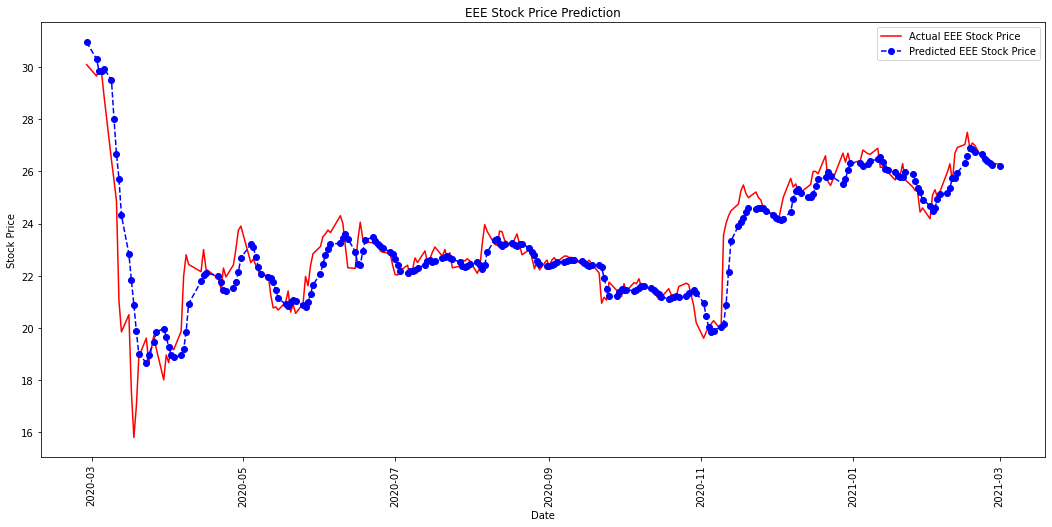

In [38]:
# Visualisation of ARIMA results
test_set_date_range = df[split:].index
plt.plot(test_set_date_range, test_set, color = 'red', label = 'Actual ' + symbol + ' Stock Price')
plt.plot(test_set_date_range, predicted_set, color = 'blue', marker='o', linestyle='dashed', label = 'Predicted ' + symbol + ' Stock Price')

plt.title(symbol + ' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [39]:

new_data = pd.DataFrame(df[-1:].values, index=df[-1:].index, columns=df.columns)

new_data

df2 = df.append(new_data)

dataset_train = df2.iloc[:split, 1:2]
dataset_test = df2.iloc[split:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(days, inputs.shape[0]):
    X_test.append(inputs[i-days:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Next Predicted price = ", float(predicted_stock_price[-1]))

Next Predicted price =  26.434120178222656


## ARIMA ##

Autoregressive ntegrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to do forecasting, i.e. predict future points in the series. 


In [40]:
df.head()

,Trade Date,High,Low,Open,Close,Volume,Prev. Close,Total Turnover,Num. Of Trans.,Unnamed: 9
Date,,,,,,,,,,
2016-03-02,2/3/2016,17.98,17.51,17.81,17.51,74696,17.82,1322081.0,205,NaN
2016-03-03,3/3/2016,17.87,17.49,17.67,17.84,10749,17.51,190705.0,67,NaN
2016-03-04,4/3/2016,18.09,17.74,17.84,17.74,59758,17.84,1066810.0,187,NaN
2016-03-07,7/3/2016,18.23,17.75,17.78,18.23,18960,17.74,342530.0,93,NaN
2016-03-08,8/3/2016,18.13,17.86,17.93,17.90,72885,18.23,1309791.0,218,NaN


In [41]:
# Supress ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [42]:
# Create training and test datasets

perc = 0.8 # percentage of training data
split = int(df.shape[0] * perc) #800

training_set = df.iloc[:split, 3:4].values
test_set = df.iloc[split:, 3:4].values

In [43]:
# Create and fit ARIMA model

actual_set = [x for x in training_set]

#print(actual_set[-5:])
predicted_set = []
test_len = len(test_set)
for time_point in range(test_len):
    model_init = ARIMA(actual_set, order=(4,1,0)) #(1,1,0)
    model = model_init.fit()
    forecast = model.forecast()
    #print('time_point:',time_point)
    #print('len(forecast) :',len(forecast))
    pred_value = forecast[0]
    #print('forecast[0]:',pred_value)
    predicted_set.append(pred_value)
    #print(pred_value)
    actual_test_value = test_set[time_point]
    #print('actual_test_value:',actual_test_value)
    actual_set.append(actual_test_value)

In [44]:
# Find Mean Squared Error    
MSE = mean_squared_error(test_set, predicted_set)
print('ARIMA Mean Squared Error is {}'.format(MSE))

# Model Summary
print(model.summary().tables[1])
#predicted_set[-5:]

ARIMA Mean Squared Error is 0.42512533718364803
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0563      0.020      2.811      0.005       0.017       0.096
ar.L2          0.0130      0.020      0.648      0.517      -0.026       0.052
ar.L3          0.0895      0.014      6.219      0.000       0.061       0.118
ar.L4          0.0527      0.021      2.468      0.014       0.011       0.094
sigma2         0.1810      0.003     57.322      0.000       0.175       0.187


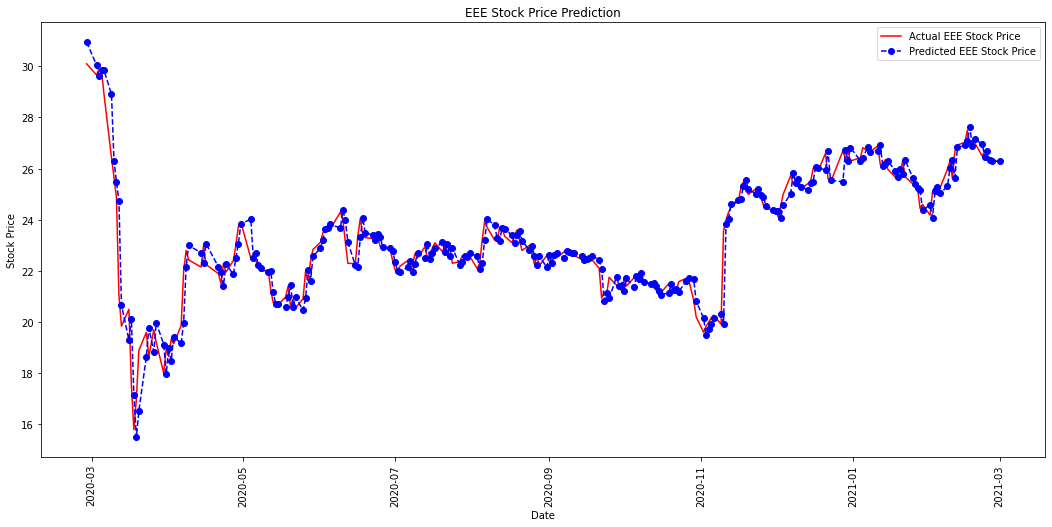

In [45]:
# Visualisation of the results
test_set_date_range = df[split:].index
plt.plot(test_set_date_range, test_set, color='red', label = 'Actual ' + symbol + ' Stock Price') 
plt.plot(test_set_date_range, predicted_set, color='b', marker='o', linestyle='dashed',  label = 'Predicted ' + symbol + ' Stock Price')
plt.title(symbol + ' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=90)
#plt.xticks(np.arange(0,1200,50), df.index[0:1200:50])
plt.legend()
plt.show()

In [46]:
# Make predictions for n values forward
# The new predicted values are added as features in the input of the model so that we will be able to predict N steps ahead.

N_pred = 5 # n values to be predicted
split = int(df.shape[0]) 

training_set = df.iloc[:split, 3:4].values


# Create and fit ARIMA model

hist_set = [x for x in training_set]
predicted_set = []

# After each cyscle add the predicted value in the training set
for time_point in range(N_pred):
    model_init = ARIMA(hist_set, order=(4,1,0)) #(1,1,0)
    #print(time_point)
    model = model_init.fit()
    forecast = model.forecast()
    pred_value = forecast[0]
    #print(pred_value)
    predicted_set.append(pred_value)
    hist_set.append([pred_value])    

print('Predicted values for next', N_pred, 'days:',  predicted_set)

Predicted values for next 5 days: [26.254221403624737, 26.24801117409872, 26.245166374590585, 26.241037966052396, 26.23885545427332]


## Conclusion on the Notebook Analysis ##

Based on the above results, we have achieved an adequate precision in predicting the relevant stocks with ARIMA. Moreover by comparing the MSE and the Visualisations of the prediction with the two models, LSTM and ARIMA, we can derive that ARIMA suits better to our stock data. Thus, in the web app that has been created,  the ARIMA Model is used yo make relevant stock predictions.
